# Explanation

    *Folder Iteration:* The script navigates through each directory in SAR_Image_Colorization_Pairs.
    *Path Construction:* For each directory (e.g., Pair-1), it constructs paths to SAR-Image-1.jpg and Optical-Image-1.jpg.
    **Image Loading and Preprocessing:**
        *SAR Image:* Loaded in grayscale and normalized to [0,1].
        *Optical Image:* Loaded in color, converted to HSV, and normalized.
    Storage: Each pair is added to a list that is later converted to a numpy array.

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf  # Make sure TensorFlow is installed

# Define the path to the main directory
base_dir = 'SAR_Image_Colorization_Pairs'

# Initialize lists to store paired data
sar_images = []
optical_images = []

# Iterate through each pair directory
for pair_dir in sorted(os.listdir(base_dir)):
    pair_path = os.path.join(base_dir, pair_dir)
    
    # Check if it's a directory
    if os.path.isdir(pair_path):
        # Load SAR and Optical images
        sar_image_path = os.path.join(pair_path, f"SAR-Image-{pair_dir.split('-')[1]}.jpg")
        optical_image_path = os.path.join(pair_path, f"Optical-Image-{pair_dir.split('-')[1]}.jpg")
        
        # Read images
        sar_image = cv2.imread(sar_image_path, cv2.IMREAD_GRAYSCALE)  # SAR as grayscale
        optical_image = cv2.imread(optical_image_path, cv2.IMREAD_COLOR)  # Optical as color

        # Normalize and preprocess images
        sar_image = sar_image / 255.0  # Normalize to [0,1]
        optical_hsv = cv2.cvtColor(optical_image, cv2.COLOR_BGR2HSV) / 255.0  # Convert optical to HSV and normalize
        
        # Store SAR intensity and optical HSV images
        sar_images.append(sar_image)
        optical_images.append(optical_hsv)

# Convert lists to numpy arrays for easy batch processing
sar_images = np.array(sar_images)

sar_images=np.expand_dims(sar_images,axis=-1)
optical_images = np.array(optical_images)

print("Loaded SAR and Optical image pairs successfully.")
print(f"SAR Images Tensor Shape: {sar_images.shape}")
print(f"Optical Images Tensor Shape: {optical_images.shape}")


2024-11-01 21:20:35.431516: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-01 21:20:35.451191: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-01 21:20:35.645111: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-01 21:20:35.805301: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-01 21:20:36.090553: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

Loaded SAR and Optical image pairs successfully.
SAR Images Tensor Shape: (3, 1733, 2500, 1)
Optical Images Tensor Shape: (3, 1733, 2500, 3)


In [2]:
target_shape = (224, 224)

resized_sar_images = tf.image.resize(sar_images, target_shape)
resized_optical_images = tf.image.resize(optical_images, target_shape)

(224, 224, 3)

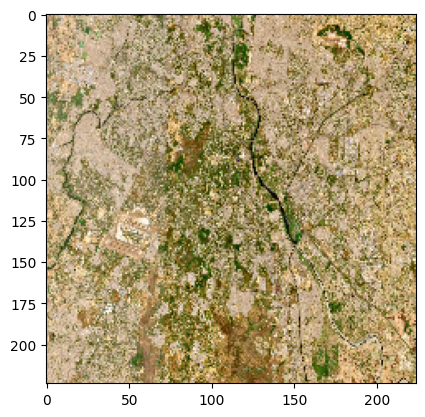

In [3]:
import matplotlib.pyplot as plt
img = cv2.imread("SAR_Image_Colorization_Pairs/Pair-1/Optical-Image-1.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

img = cv2.resize(img, (224, 224))
plt.imshow(img)
img.shape

(512, 512, 3)

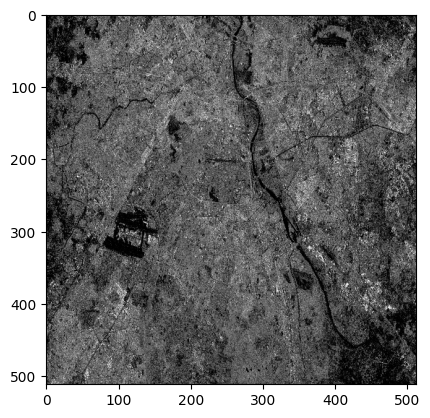

In [4]:
import matplotlib.pyplot as plt
img = cv2.imread("SAR_Image_Colorization_Pairs/Pair-1/SAR-Image-1.jpg")
#img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

img = cv2.resize(img, (512, 512))
plt.imshow(img)
img.shape

In [5]:
resized_sar_images.shape

TensorShape([3, 224, 224, 1])

In [6]:
resized_optical_images.shape

TensorShape([3, 224, 224, 3])

# image preprocessing

In [147]:
import numpy as np

def grayscale_to_rgb(images):
    # Convert grayscale images to RGB by repeating the single channel three times
    return np.repeat(images, 3, axis=-1)


In [148]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize ImageDataGenerator for augmentation
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Assuming sar_images and optical_images are numpy arrays
# Shape: sar_images -> (num_samples, height, width, 1)
# Shape: optical_images -> (num_samples, height, width, 3)


In [149]:
import numpy as np
import tensorflow as tf

def custom_data_generator(sar_images, optical_images, batch_size, data_gen):
    while True:  # Loop forever so the generator never terminates
        for start in range(0, len(sar_images), batch_size):
            end = min(start + batch_size, len(sar_images))
            batch_sar_images = sar_images[start:end]
            batch_optical_images = optical_images[start:end]

            # Ensure that the images are numpy arrays for augmentation
            batch_sar_images_np = batch_sar_images.numpy() if isinstance(batch_sar_images, tf.Tensor) else batch_sar_images
            batch_optical_images_np = batch_optical_images.numpy() if isinstance(batch_optical_images, tf.Tensor) else batch_optical_images
            
            # Apply augmentation to both SAR and optical images
            augmented_sar = np.array([data_gen.random_transform(img) for img in batch_sar_images_np])
            augmented_optical = np.array([data_gen.random_transform(img) for img in batch_optical_images_np])

            yield [augmented_sar, augmented_optical], augmented_optical  # Yield inputs and targets


In [150]:
def create_tf_dataset(sar_images, optical_images, batch_size, data_gen):
    output_signature = (
        (tf.TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32),  # SAR input
         tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32)), # Optical input
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32)      # Target output
    )
    
    return tf.data.Dataset.from_generator(
        lambda: custom_data_generator(sar_images, optical_images, batch_size, data_gen),
        output_signature=output_signature
    )


# implementing ResUnet architecture
•ResUNet Backbone: Combines U-Net and residual networks with
7 convolutional layers (3x3 filters), LReLU activation, and batch
normalization for stability.
•Skip Connections: Retain spatial information during colorization.
•Residual Blocks: Ensure consistent information flow via input-
output addition

In [7]:
# import keras modules and its important APIs

import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as k
from keras.models import Model
#from keras datasets import cifar10
import numpy as np
import os

In [8]:
from tensorflow.keras.layers import Add, Input, Conv2D, BatchNormalization, LeakyReLU, UpSampling2D,Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D

In [9]:
def d_block(inputs, num_filters):
    x = Conv2D(num_filters, kernel_size=3, padding='same', kernel_initializer='he_normal')(inputs)
    #x = MaxPooling2D(pool_size=(2,2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(num_filters, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
    #x = MaxPooling2D(pool_size=(2,2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    #x = MaxPooling2D(pool_size=(2,2))(x)
    return x

In [10]:
def bridge_block(inputs, num_filters):
    x = BatchNormalization()(inputs)
    x = LeakyReLU()(x)
    x = Conv2D(num_filters, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
    #x = MaxPooling2D(pool_size=(2,2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    #x = MaxPooling2D(pool_size=(2,2))(x)
    return x

In [11]:
def initial_block(inputs,num_filters):
    x = Conv2D(num_filters, kernel_size=3, padding='same',kernel_initializer='he_normal')(inputs)
    #x = MaxPooling2D(pool_size=(2,2))(x)
    x = BatchNormalization()(inputs)
    x = LeakyReLU()(x)
    return x

In [12]:
def u_block(inputs, skip_connection, num_filters):
   # x = UpSampling2D(size=(2, 2))(inputs)
    x=inputs
    x = Conv2D(num_filters, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    # Concatenate with the skip connection
    """if x.shape[1:] != skip_connection.shape[1:]:
        skip_connection = UpSampling2D(size=(2, 2))(skip_connection)"""
    x = Concatenate()([x, skip_connection])

    x = Conv2D(num_filters, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    return x

In [157]:
"""from tensorflow.keras.layers import Layer
import tensorflow as tf

class ResizeLayer(Layer):
    def __init__(self, target_height, target_width, **kwargs):
        super(ResizeLayer, self).__init__(**kwargs)
        self.target_height = target_height
        self.target_width = target_width

    def call(self, inputs):
        return tf.image.resize_with_crop_or_pad(inputs, self.target_height, self.target_width)

def u_block(inputs, skip_connection, num_filters):
    #x = UpSampling2D(size=(2, 2))(inputs)
    x = Conv2D(num_filters, kernel_size=3, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    # Wrap tf.image.resize_with_crop_or_pad in a custom layer
    skip_connection_cropped = ResizeLayer(target_height=x.shape[1], target_width=x.shape[2])(skip_connection)

    x = Concatenate()([x, skip_connection_cropped])

    x = Conv2D(num_filters, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    return x"""

"from tensorflow.keras.layers import Layer\nimport tensorflow as tf\n\nclass ResizeLayer(Layer):\n    def __init__(self, target_height, target_width, **kwargs):\n        super(ResizeLayer, self).__init__(**kwargs)\n        self.target_height = target_height\n        self.target_width = target_width\n\n    def call(self, inputs):\n        return tf.image.resize_with_crop_or_pad(inputs, self.target_height, self.target_width)\n\ndef u_block(inputs, skip_connection, num_filters):\n    #x = UpSampling2D(size=(2, 2))(inputs)\n    x = Conv2D(num_filters, kernel_size=3, padding='same', kernel_initializer='he_normal')(inputs)\n    x = BatchNormalization()(x)\n    x = LeakyReLU()(x)\n\n    # Wrap tf.image.resize_with_crop_or_pad in a custom layer\n    skip_connection_cropped = ResizeLayer(target_height=x.shape[1], target_width=x.shape[2])(skip_connection)\n\n    x = Concatenate()([x, skip_connection_cropped])\n\n    x = Conv2D(num_filters, kernel_size=3, padding='same', kernel_initializer='he_no

In [13]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model
def ResUNet(input_shape_sar,input_shape_optical):
    # Define inputs for SAR and Optical images
    
    sar_input=Input(shape=input_shape_sar) # e.g., (height, width, channels)
    optical_input= Input(shape=input_shape_optical)
    
    # Encoding path for SAR input
    #d0_sar=initial_block(sar_input,num_filters=8)
    d1_sar = d_block(sar_input, num_filters=16)
    print("Shape after d1_sar:", d1_sar.shape)

    d2_sar = d_block(d1_sar, num_filters=32)
    print("Shape after d2_sar:", d2_sar.shape)

    d3_sar = d_block(d2_sar, num_filters=64)
    print("Shape after d3_sar:", d3_sar.shape)

    # Repeat this for optical input


    # Encoding path for Optical input
    #d0_optical = d_block(optical_input, num_filters=8)
    d1_optical = d_block(optical_input, num_filters=16)
    print("Shape after d1_optical:", d1_optical.shape)
    d2_optical = d_block(d1_optical, num_filters=32)
    print("Shape after d2_optical:", d2_optical.shape)
    d3_optical = d_block(d2_optical, num_filters=64)
    print("Shape after d3_optical:", d3_optical.shape)
    #d3_optical = Conv2D(filters=64, kernel_size=3, padding='same', kernel_initializer='he_normal')(d2_optical)
    #combine features from both paths - cancatenate
    combined = Add()([d3_sar, d3_optical]) #or concatenate -##[1733,2500,64]
    print("Shape after combined:", combined.shape)
    
    # Bridge
    bridge = bridge_block(combined, num_filters=128) ##[1733,2500,128]
    print("Shape after bridge:", bridge.shape)
    # Decoding path (Upsampling)
    u1 = u_block(bridge, d3_sar, num_filters=64)  # Use skip connection from SAR
    print("Shape after u1:", u1.shape)
    u2 = u_block(u1, d2_sar, num_filters=32)      # Use skip connection from SAR
    print("Shape after u2:", u2.shape)
    u3 = u_block(u2, d1_sar, num_filters=16)      # Use skip connection from SAR
    print("Shape after u3:", u3.shape)
    #u4 = u_block(u3, d0_sar, num_filters=8)      # Use skip connection from SAR
    # Output layer
    outputs = Conv2D(3, kernel_size=1, activation='tanh')(u3)
    model = Model(inputs=[sar_input, optical_input], outputs=outputs)
    model.summary()
    return model


# training the model

In [159]:
"""import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Updated custom data generator function
def custom_data_gen(sar_images, optical_images, batch_size):
    while True:
        indices = np.random.randint(0, len(sar_images), batch_size)
        sar_batch = sar_images[indices]
        optical_batch = optical_images[indices]
        yield ([sar_batch, optical_batch], optical_batch)  # Input: SAR & Optical, Output: Optical

# Specify output signature for Dataset
output_signature = (
    (
        tf.TensorSpec(shape=(None, *input_shape_sar), dtype=tf.float32),  # SAR input shape
        tf.TensorSpec(shape=(None, *input_shape_optical), dtype=tf.float32)  # Optical input shape
    ),
    tf.TensorSpec(shape=(None, *input_shape_optical), dtype=tf.float32)  # Output shape
)

# Create the dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: custom_data_gen(sar_images, optical_images, batch_size),
    output_signature=output_signature
)
"""


'import numpy as np\nfrom tensorflow.keras.preprocessing.image import ImageDataGenerator\nimport tensorflow as tf\n\n# Updated custom data generator function\ndef custom_data_gen(sar_images, optical_images, batch_size):\n    while True:\n        indices = np.random.randint(0, len(sar_images), batch_size)\n        sar_batch = sar_images[indices]\n        optical_batch = optical_images[indices]\n        yield ([sar_batch, optical_batch], optical_batch)  # Input: SAR & Optical, Output: Optical\n\n# Specify output signature for Dataset\noutput_signature = (\n    (\n        tf.TensorSpec(shape=(None, *input_shape_sar), dtype=tf.float32),  # SAR input shape\n        tf.TensorSpec(shape=(None, *input_shape_optical), dtype=tf.float32)  # Optical input shape\n    ),\n    tf.TensorSpec(shape=(None, *input_shape_optical), dtype=tf.float32)  # Output shape\n)\n\n# Create the dataset\ntrain_dataset = tf.data.Dataset.from_generator(\n    lambda: custom_data_gen(sar_images, optical_images, batch_size

In [24]:
#sasr# Split the images
train_sar = resized_sar_images[:2]          # First 2 images for training
train_optical = resized_optical_images[:2]  # Corresponding optical images for training

val_sar = resized_sar_images[2:3]           # 1 image for validation
val_optical = resized_optical_images[2:3]   # Corresponding optical image for validation

# Assuming you have a separate test image, load it similarly
test_sar = resized_sar_images[2:3]          # Or any other separate test image
test_optical = resized_optical_images[2:3]   # Corresponding optical image for testing


In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
#batch_size=10
#setting Training Hyperparameters
batch_size= 1
epochs=1500
data_augmentation=True
# Update your checkpoint to use 'val_accuracy'
checkpoint = ModelCheckpoint("Res_UNET.keras", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

# Update early stopping to monitor 'val_accuracy' with mode='max'
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='max')

# Ensure your steps_per_epoch and validation_steps are set appropriately
steps_per_epoch = len(sar_images) // batch_size  # Adjust based on your data
#validation_steps = len(test_sar) // batch_size   # Adjust based on your data


In [162]:
# setting LR for different number of Epochs
def lr_schedule(epoch):
    lr=le-3
    if epoch >180:
        lr *= 0.5e-3
    elif epoch >160:
        lr *= 1e-3
    elif epoch >120:
        lr *= le-2
    elif epoch >80:
        lr *=1e-1
    print('Learning rate: ', lr)
    return lr

In [163]:
train_dataset = create_tf_dataset(resized_sar_images, resized_optical_images, batch_size, data_gen)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [17]:
resized_sar_images.shape

TensorShape([3, 224, 224, 1])

In [18]:
input_shape_sar=[224, 224, 1]
input_shape_optical=[224, 224, 3]
model=ResUNet(input_shape_sar,input_shape_optical) # for SAR images
# Define the input shape
opt = Adam(learning_rate=0.0001)

model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])
# Now you can fit your model
history = model.fit(
    x=[train_sar, train_optical],            # Training inputs
    y=train_optical,                          # Training targets
    validation_data=([val_sar, val_optical], val_optical),  # Validation data
    steps_per_epoch=steps_per_epoch,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[checkpoint, early]
)

# Evaluate your model on the test data
# model.evaluate([test_sar, test_optical], test_optical)

Shape after d1_sar: (None, 224, 224, 16)
Shape after d2_sar: (None, 224, 224, 32)
Shape after d3_sar: (None, 224, 224, 64)
Shape after d1_optical: (None, 224, 224, 16)
Shape after d2_optical: (None, 224, 224, 32)
Shape after d3_optical: (None, 224, 224, 64)
Shape after combined: (None, 224, 224, 64)
Shape after bridge: (None, 224, 224, 128)
Shape after u1: (None, 224, 224, 64)
Shape after u2: (None, 224, 224, 32)
Shape after u3: (None, 224, 224, 16)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 224, 224,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │         64 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      2,320 │ leaky_re_lu[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 224, 224,  │      2,320 │ leaky_re_lu_6[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │         64 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 224, 224,  │      4,640 │ leaky_re_lu_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 224, 224,  │      4,640 │ leaky_re_lu_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_2[0][0]  

 Total params: 414,995 (1.58 MB)

 Trainable params: 413,267 (1.58 MB)

 Non-trainable params: 1,728 (6.75 KB)

Epoch 1/1500


/home/reshni/py3_env/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2/3 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3334 - loss: 0.6403   

2024-11-01 21:22:59.465286: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 1: val_accuracy improved from -inf to 0.21235, saving model to Res_UNET.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.2996 - loss: 0.5672 - val_accuracy: 0.2124 - val_loss: 1.0535
Epoch 2/1500
2/3 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.4594 - loss: 0.4812

2024-11-01 21:23:11.880589: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 2: val_accuracy did not improve from 0.21235
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.4081 - loss: 0.4277 - val_accuracy: 0.2109 - val_loss: 1.1573
Epoch 3/1500
2/3 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.4906 - loss: 0.4149
Epoch 3: val_accuracy did not improve from 0.21235
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.4388 - loss: 0.3645 - val_accuracy: 0.1543 - val_loss: 1.1183
Epoch 4/1500
2/3 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.5176 - loss: 0.3381

2024-11-01 21:23:29.305286: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 4: val_accuracy did not improve from 0.21235
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.4636 - loss: 0.2969 - val_accuracy: 0.1788 - val_loss: 1.0544
Epoch 5/1500
2/3 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.5720 - loss: 0.2598
Epoch 5: val_accuracy did not improve from 0.21235
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.5065 - loss: 0.2314 - val_accuracy: 0.2043 - val_loss: 1.1046
Epoch 6/1500
2/3 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6191 - loss: 0.2143 
Epoch 6: val_accuracy improved from 0.21235 to 0.21572, saving model to Res_UNET.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.5492 - loss: 0.1911 - val_accuracy: 0.2157 - val_loss: 1.2144
Epoch 7/1500
2/3 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6481 - loss: 0.1949
Epoch 7: val_accuracy did not improve from 0.21572
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5790 - loss: 0.1715 - val_accuracy: 0.2152 - val_loss: 1.3127
Epoch 8/1500
2/3 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy:

2024-11-01 21:24:08.767683: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 8: val_accuracy did not improve from 0.21572
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.6200 - loss: 0.1418 - val_accuracy: 0.2141 - val_loss: 1.3285
Epoch 9/1500
2/3 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7077 - loss: 0.1448
Epoch 9: val_accuracy did not improve from 0.21572
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.6281 - loss: 0.1274 - val_accuracy: 0.2154 - val_loss: 1.3214
Epoch 10/1500
2/3 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.7258 - loss: 0.1275
Epoch 10: val_accuracy improved from 0.21572 to 0.21763, saving model to Res_UNET.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.6440 - loss: 0.1122 - val_accuracy: 0.2176 - val_loss: 1.1866
Epoch 11/1500
2/3 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7439 - loss: 0.1134
Epoch 11: val_accuracy improved from 0.21763 to 0.21771, saving model to Res_UNET.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.6595 - loss: 0.0998 - val_accuracy: 0.2177 - val_loss: 1.3873
Epoch 12/1500
2/3 ━━

2024-11-01 21:25:46.980562: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 16: val_accuracy did not improve from 0.21863
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.6830 - loss: 0.0618 - val_accuracy: 0.2128 - val_loss: 1.3901
Epoch 17/1500
2/3 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7908 - loss: 0.0650
Epoch 17: val_accuracy did not improve from 0.21863
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6998 - loss: 0.0570 - val_accuracy: 0.1895 - val_loss: 1.4082
Epoch 18/1500
2/3 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7622 - loss: 0.0536
Epoch 18: val_accuracy did not improve from 0.21863
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.6812 - loss: 0.0482 - val_accuracy: 0.1577 - val_loss: 1.4169
Epoch 19/1500
2/3 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.7700 - loss: 0.0494
Epoch 19: val_accuracy did not improve from 0.21863
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.6883 - loss: 0.0446 - val_accuracy: 0.0838 - val_loss: 1.3198
Epoch 20/1500
2/3 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7895 - loss: 0.0458
Epoch

2024-11-01 21:28:52.338057: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 32: val_accuracy did not improve from 0.47030
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.7514 - loss: 0.0223 - val_accuracy: 0.3617 - val_loss: 0.4213
Epoch 33/1500
2/3 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.8466 - loss: 0.0243
Epoch 33: val_accuracy did not improve from 0.47030
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.7562 - loss: 0.0218 - val_accuracy: 0.2006 - val_loss: 0.7053
Epoch 34/1500
2/3 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.8813 - loss: 0.0251
Epoch 34: val_accuracy did not improve from 0.47030
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.7798 - loss: 0.0221 - val_accuracy: 0.1703 - val_loss: 0.7943
Epoch 35/1500
2/3 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8872 - loss: 0.0241
Epoch 35: val_accuracy did not improve from 0.47030
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7848 - loss: 0.0212 - val_accuracy: 0.2126 - val_loss: 0.6316
Epoch 36/1500
2/3 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.8905 - loss: 0.0232
Epoch

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


2/3 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.8967 - loss: 0.0177  

2024-11-01 21:35:11.619476: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 64: val_accuracy did not improve from 0.76495
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.7926 - loss: 0.0158 - val_accuracy: 0.1681 - val_loss: 1.0099
Epoch 65/1500
2/3 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.8610 - loss: 0.0179
Epoch 65: val_accuracy did not improve from 0.76495
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.7693 - loss: 0.0157 - val_accuracy: 0.1842 - val_loss: 0.9888
Epoch 66/1500
2/3 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step - accuracy: 0.9028 - loss: 0.0160
Epoch 66: val_accuracy did not improve from 0.76495
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.7985 - loss: 0.0143 - val_accuracy: 0.2022 - val_loss: 0.9838
Epoch 67/1500
2/3 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.8683 - loss: 0.0164
Epoch 67: val_accuracy did not improve from 0.76495
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.7753 - loss: 0.0145 - val_accuracy: 0.2031 - val_loss: 0.9624
Epoch 68/1500
2/3 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9021 - loss: 0.0149
Epoc

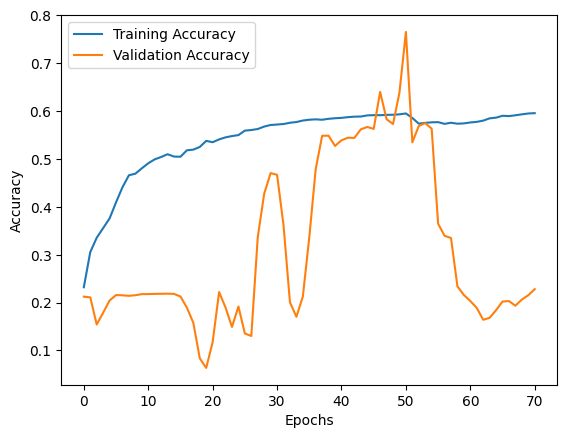

In [50]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Use 'val_accuracy' here
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


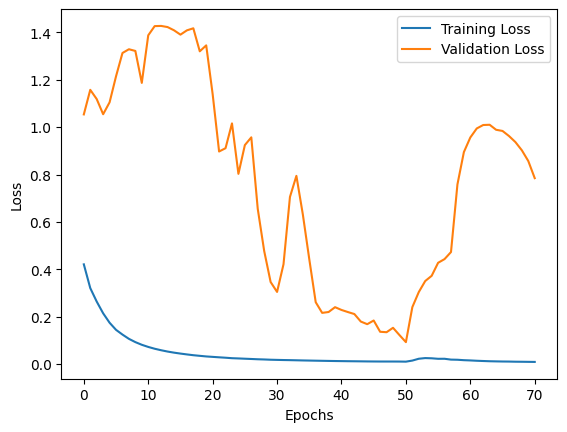

In [51]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')  # Use 'val_loss' here
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [35]:
print(type(train_sar[0]))

<class 'tensorflow.python.framework.ops.EagerTensor'>


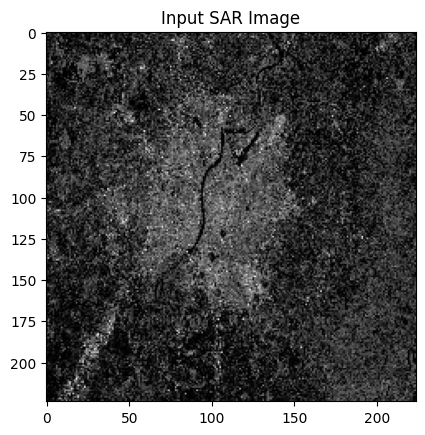

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.03925125..359.69107].


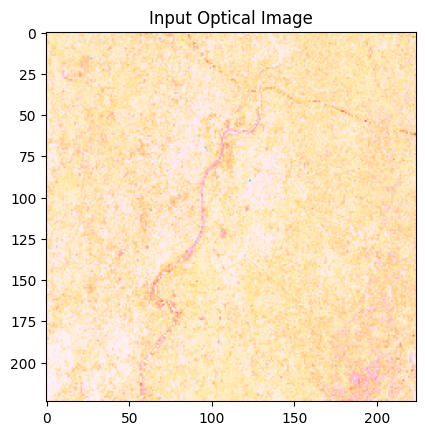

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17857672..7475.901].


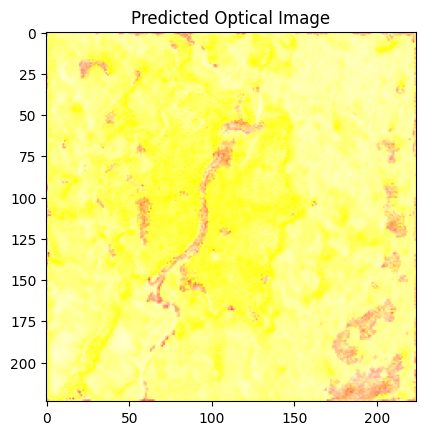

In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Display the SAR input image
img_sar = np.array(test_sar[0])
img_sar = cv2.cvtColor(img_sar, cv2.COLOR_BGR2RGB)
plt.imshow(img_sar)
plt.title("Input SAR Image")
plt.show()

# Display the Optical input image
img_optical = np.array(test_optical[0])
img_optical = cv2.cvtColor(img_optical, cv2.COLOR_BGR2HSV)
plt.imshow(img_optical)
plt.title("Input Optical Image")
plt.show()

# Expand dimensions for SAR and Optical images to add batch dimension
sar_input = np.expand_dims(test_sar[0], axis=0)
optical_input = np.expand_dims(test_optical[0], axis=0)

# Predict the output using both SAR and Optical images as inputs
y_pred = model.predict([sar_input, optical_input])

# Display the predicted image (assumed to be similar to optical image)
img_pred = np.array(y_pred[0])
img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2HSV)
plt.imshow(img_pred)
plt.title("Predicted Optical Image")
plt.show()


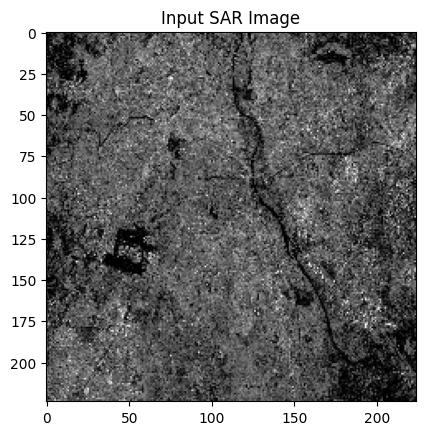

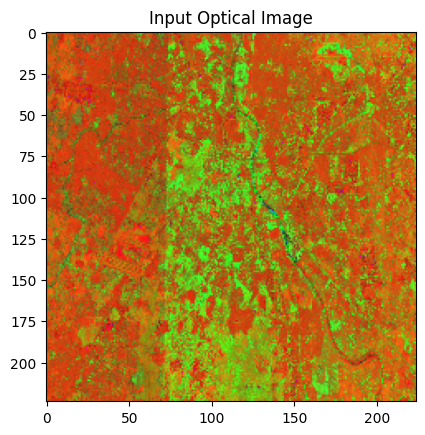

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8340328].


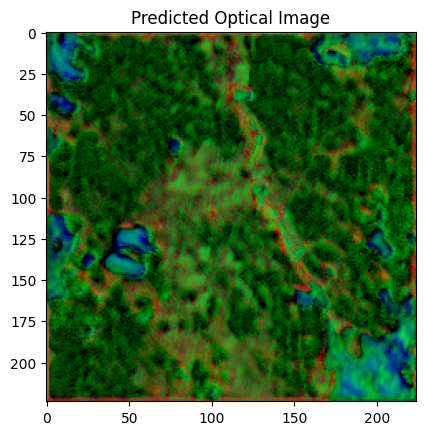

In [55]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Display the SAR input image
img_sar = np.array(train_sar[0])
img_sar = cv2.cvtColor(img_sar, cv2.COLOR_BGR2RGB)
plt.imshow(img_sar)
plt.title("Input SAR Image")
plt.show()

# Display the Optical input image
img_optical = np.array(train_optical[0])
img_optical = cv2.cvtColor(img_optical, cv2.COLOR_BGR2RGB)
plt.imshow(img_optical)
plt.title("Input Optical Image")
plt.show()

# Expand dimensions for SAR and Optical images to add batch dimension
sar_input = np.expand_dims(train_sar[0], axis=0)
optical_input = np.expand_dims(train_optical[0], axis=0)

# Predict the output using both SAR and Optical images as inputs
y_pred = model.predict([sar_input, optical_input])

# Display the predicted image (assumed to be similar to optical image)
img_pred = np.array(y_pred[0])
img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
plt.imshow(img_pred)
plt.title("Predicted Optical Image")
plt.show()


In [2]:
from tensorflow.keras.models import load_model

model = load_model('Res_UNET.keras')